In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ito_diffusions import *
from ou_fitting import *
from scipy.stats import laplace
plt.style.use('dark_background')

In [2]:
params = {
    'font.size': 14,
    'figure.figsize': (11,18),
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
}
plt.rcParams.update(params)

In [3]:
DAYS_IN_YEAR = 252
T = 8
SCHEME_STEPS = int(DAYS_IN_YEAR*T)

In [4]:
std_dev_weight = 1.0
n_quadrature = 15

## Ornstein-Uhlenbeck with jumps

$dX_t = \lambda(\theta_0-X_t)dt + \sigma dW_t + dJ_t$ where the jump process $J_t$ has constant Poisson intensity $m$ and jump size distribution $Laplace(\gamma)$.

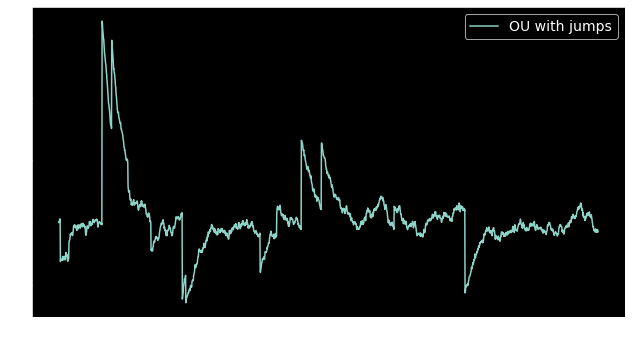

In [5]:
fig, ax = plt.subplots(figsize=(9,5), nrows=1, ncols=1)

mean_reversion = 5.0
long_term = 0.0
vol = 0.4

jump_intensity = 2.0
jump_size_scale = 1.0
jump_size_distr = laplace(loc=0.0, scale=1/jump_size_scale)

jump_params = {
    'jump_intensity_func': lambda t,x: jump_intensity,
    'jump_size_distr': jump_size_distr,
}

OU = Vasicek(x0=0.0, T=T, scheme_steps=SCHEME_STEPS, 
             vol=vol, long_term=long_term, mean_reversion=mean_reversion,
             jump_params=jump_params
            )

df = OU.simulate()

ax.plot(df, label='OU with jumps')
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

## Estimate all parameters at once

In [6]:
fitter = OU_jump_Laplace_fitter(theta_init_mode='random',
                                std_dev_weight=std_dev_weight,
                                n_quadrature=n_quadrature,
                               )
fitter.df = df
fitter.regularization = 0.0

In [7]:
fitter.theta_init

[1.1185844360370023,
 -0.8889929225216948,
 0.6225793381123871,
 0.7022642620575977,
 4.294596240303898]

In [8]:
fit_info = fitter.fit()
fit_info

      fun: 0.0013477958538186965
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.07406617e-09, -1.25203667e-07,  0.00000000e+00, -4.56665955e-08,
        1.31405303e-08])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 198
      nit: 27
   status: 0
  success: True
        x: array([ 5.42908756, -0.01387602,  0.        ,  1.06718755,  2.12248188])

In [9]:
print('Ground truth:')
print('mean reversion: {:.2f}'.format(OU.mean_reversion))
print('long term: {:.2f}'.format(OU.long_term))
print('vol: {:.2%}'.format(OU.vol_double))
print('intensity: {:.2f}'.format(jump_intensity))
print('jump size scale: {:.2f}'.format(jump_size_scale))

print('\nFitted:')
print('mean reversion: {:.2f}'.format(fitter.theta[0]))
print('long term: {:.2f}'.format(fitter.theta[1]))
print('vol: {:.0%}'.format(fitter.theta[2]))
print('intensity: {:.2f}'.format(fitter.theta[4]))
print('jump size scale: {:.2f}'.format(fitter.theta[3]))

print('\nRegression (diffusion only):')
print('mean reversion (annualized): {:.2f}'.format(fitter.theta_regression()[0]))
print('long term: {:.2f}'.format(fitter.theta_regression()[1]))
print('vol (annualized): {:.0%}'.format(fitter.vol_estimate()))

Ground truth:
mean reversion: 5.00
long term: 0.00
vol: 40.00%
intensity: 2.00
jump size scale: 1.00

Fitted:
mean reversion: 5.43
long term: -0.01
vol: 0%
intensity: 2.12
jump size scale: 1.07

Regression (diffusion only):
mean reversion (annualized): 4.52
long term: 0.06
vol (annualized): 43%


## Ornstein-Uhlenbeck with jumps, only fit jump parameters

In [10]:
fitter = OU_jump_only_Laplace_fitter(theta_init_mode='random',
                                     std_dev_weight=std_dev_weight,
                                     n_quadrature=n_quadrature,
                                    )
fitter.df = df
fitter.theta_diffusion = [mean_reversion, long_term, vol]
fitter.regularization = 0.0

In [11]:
fitter.theta_init

[0.8785709288617616, 4.117365723655554]

In [12]:
fit_info = fitter.fit()
fit_info

      fun: 0.001660299380684747
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.79407270e-06,  1.13208054e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 57
      nit: 17
   status: 0
  success: True
        x: array([0.96759679, 1.58316731])

In [13]:
print('Ground truth:')
print('intensity: {:.2f}'.format(jump_intensity))
print('jump size scale: {:.2f}'.format(jump_size_scale))

print('\nFitted:')
print('intensity: {:.2f}'.format(fitter.theta[1]))
print('jump size scale: {:.2f}'.format(fitter.theta[0]))

Ground truth:
intensity: 2.00
jump size scale: 1.00

Fitted:
intensity: 1.58
jump size scale: 0.97


## Estimate all parameters except mean-reversion

In [14]:
fitter = OU_jump_Laplace_fixed_mr_fitter(theta_init_mode='random',
                                         std_dev_weight=std_dev_weight,
                                         n_quadrature=n_quadrature,
                                        )
fitter.df = df
fitter.regularization = 0.0

In [15]:
fitter.theta_init

[-0.47418766754291797,
 0.697216642360851,
 0.41799813404170433,
 1.289924567306348]

In [16]:
fit_info = fitter.fit()
fit_info

      fun: 0.0013447165693643973
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 8.78396748e-06,  2.46796941e-06, -4.57147341e-06,  2.89442949e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 145
      nit: 25
   status: 0
  success: True
        x: array([-0.01387905,  0.35127188,  0.96841278,  1.44923268])

In [17]:
print('Ground truth:')
print('mean reversion: {:.2f}'.format(OU.mean_reversion))
print('long term: {:.2f}'.format(OU.long_term))
print('vol: {:.2%}'.format(OU.vol_double))
print('intensity: {:.2f}'.format(jump_intensity))
print('jump size scale: {:.2f}'.format(jump_size_scale))

print('\nFitted:')
print('mean reversion: {:.2f}'.format(fitter.theta_regression()[0]))
print('long term: {:.2f}'.format(fitter.theta[0]))
print('vol: {:.0%}'.format(fitter.theta[1]))
print('intensity: {:.2f}'.format(fitter.theta[3]))
print('jump size scale: {:.2f}'.format(fitter.theta[2]))

Ground truth:
mean reversion: 5.00
long term: 0.00
vol: 40.00%
intensity: 2.00
jump size scale: 1.00

Fitted:
mean reversion: 4.52
long term: -0.01
vol: 35%
intensity: 1.45
jump size scale: 0.97


## Estimate all parameters except vol

Compared to mean-reversion, volatility can be estimated in a robust fashion by using inter-quantile range estimate (basically fitting a normal distribution using the quantiles rather than the moments as these are less sensitive to the large deviations coming from the jumps).

In [18]:
fitter = OU_jump_Laplace_fixed_vol_fitter(theta_init_mode='random',
                                          std_dev_weight=std_dev_weight,
                                          n_quadrature=n_quadrature,
                                         )
fitter.df = df
fitter.regularization = 0.0

In [19]:
fitter.theta_init

[2.937022214223132,
 -0.24897382765052956,
 0.3736333789701673,
 2.9173164084973653]

In [20]:
fit_info = fitter.fit()
fit_info

/home/sauxpa/Documents/python_scripts/Quant/jump_model/ou_fitting/ou_fitting_jump_laplace.py:183: RuntimeWarning: invalid value encountered in double_scalars
  return np.exp(u*long_term*1j-(u**2)*(vol**2)/(4*mean_reversion))*(gamma**2/(gamma**2+u**2))**(m/(2*mean_reversion))


      fun: 0.0013454411188796415
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.20479017e-06,  3.52365706e-07, -7.94405774e-06,  3.77363071e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 255
      nit: 26
   status: 0
  success: True
        x: array([ 4.65672199, -0.01388354,  0.92281678,  1.35715429])

In [21]:
print('Ground truth:')
print('mean reversion: {:.2f}'.format(OU.mean_reversion))
print('long term: {:.2f}'.format(OU.long_term))
print('vol: {:.2%}'.format(OU.vol_double))
print('intensity: {:.2f}'.format(jump_intensity))
print('jump size scale: {:.2f}'.format(jump_size_scale))

print('\nFitted:')
print('mean reversion: {:.2f}'.format(fitter.theta[0]))
print('long term: {:.2f}'.format(fitter.theta[1]))
print('vol: {:.0%}'.format(fitter.vol_estimate()))
print('intensity: {:.2f}'.format(fitter.theta[3]))
print('jump size scale: {:.2f}'.format(fitter.theta[2]))

print('\nRegression (diffusion only):')
print('mean reversion (annualized): {:.2f}'.format(fitter.theta_regression()[0]))
print('long term: {:.2f}'.format(fitter.theta_regression()[1]))
print('vol (annualized): {:.0%}'.format(fitter.vol_estimate()))

Ground truth:
mean reversion: 5.00
long term: 0.00
vol: 40.00%
intensity: 2.00
jump size scale: 1.00

Fitted:
mean reversion: 4.66
long term: -0.01
vol: 43%
intensity: 1.36
jump size scale: 0.92

Regression (diffusion only):
mean reversion (annualized): 4.52
long term: 0.06
vol (annualized): 43%


## Calibrating a jump model when there is none...

A good test to detect potential jumps is to calibrate a jump model : if the most likely value for jump intensity is zero then the jump hypothesis can be rejected (heuristically but this can perhaps be turned into a rigorous statistical test).

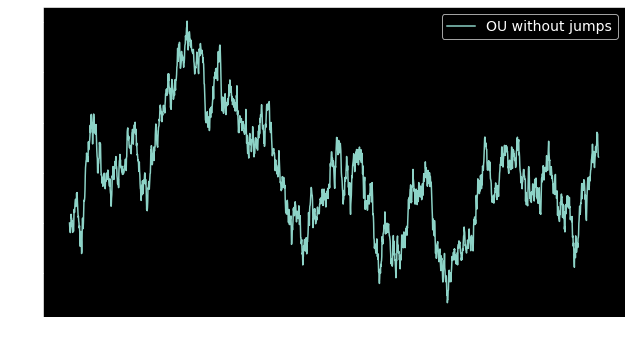

In [22]:
fig, ax = plt.subplots(figsize=(9,5), nrows=1, ncols=1)

mean_reversion = 1.0
long_term = 0.0
vol = 0.4

OU = Vasicek(x0=0.0, T=T, scheme_steps=SCHEME_STEPS, 
             vol=vol, long_term=long_term, mean_reversion=mean_reversion,
            )

df = OU.simulate()

ax.plot(df, label='OU without jumps')
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [23]:
fitter = OU_jump_only_Laplace_fitter(theta_init_mode='random',
                                     std_dev_weight=std_dev_weight,
                                     n_quadrature=n_quadrature,
                                    )
fitter.df = df
fitter.theta_diffusion = [mean_reversion, long_term, vol]
fitter.regularization = 0.0

In [24]:
fitter.theta_init

[0.6306844504770169, 4.091778116677809]

In [25]:
fit_info = fitter.fit()
fit_info

      fun: 0.07795403682517871
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.68989300e-08,  1.01862963e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 33
      nit: 10
   status: 0
  success: True
        x: array([4.86961631, 0.10754255])

In [26]:
print('Fitted:')
print('intensity: {:.2f}'.format(fitter.theta[1]))
print('jump size scale: {:.2f}'.format(fitter.theta[0]))

Fitted:
intensity: 0.11
jump size scale: 4.87
